
# HELOC Risk Prediction


### Introduction

This project aims at developing a predictive model and a decision support system (DSS) that evaluates the risk of Home Equity Line of Credit (HELOC) applications. 

We are assigned with a real-world financial dataset from an anonymized credit bureau.The 23 predictor variables are either quantitative or categorical. The target variable that we are going to predict is a binary variable called RiskPerformance. The value “Bad” means that a consumer was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. 

### Import Library

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score

### Load the data 

In [59]:
heloc = pd.read_csv('heloc_dataset_v1.csv')
heloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

In [60]:
heloc.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [61]:
heloc.columns

Index(['RiskPerformance', 'ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object')

### Data Cleaning and Data Preprocessing

1) Dealing with missing values and special values

There are no NaN in the original data.But accoring to the data dictionary,1 in column MaxDelqEver represents No such value and -9 in all columns represents No Bureau Record or No Investigation.Thus,we replaced these value with ‘nan’ and dropped rows containing these values. 

In [62]:
heloc['MaxDelqEver'] =heloc['MaxDelqEver'].replace(1, np.nan)
heloc =heloc.replace(-9, np.nan)
heloc = heloc.dropna()

Other special values: -7 and -8 in all columns means invalid values. We replaced these values with mode value of the corresponding feature using Imputer.

In [63]:
heloc = heloc.replace(-8, np.nan)
heloc = heloc.replace(-7, np.nan)

imputer = SimpleImputer(strategy="most_frequent")
for i in range(1,24):
    heloc.iloc[:, [i]] = imputer.fit_transform(heloc.iloc[:, [i]])

2) Converting the data types

For variables MaxDelq2PublicRecLast12M and MaxDelqEver, they are categorical variables that represent related records of max delinquency. These variables are converted into categorical variables to facilitate model building. 

In [64]:
categorical1 = pd.get_dummies(heloc['MaxDelq2PublicRecLast12M'],prefix='MaxDelq2PublicRecLast12M')
categorical2 = pd.get_dummies(heloc['MaxDelqEver'],prefix='MaxDelqEver')
heloc = pd.concat([heloc, categorical1,categorical2],axis = 1)

In [65]:
heloc.drop(['MaxDelq2PublicRecLast12M', 'MaxDelqEver'], axis=1, inplace=True)

In [9]:
heloc['MaxDelq2PublicRecLast12M']=OneHotEncoder(heloc['MaxDelq2PublicRecLast12M'])
heloc['MaxDelqEver']=OneHotEncoder(heloc['MaxDelqEver'])

The target variable to predict the risk is the RiskPerformance. The original data consists of two values: good and bad. RiskPeformance is factorized to 0 and 1. 0 represents bad and 1 represents good.

In [66]:
heloc['RiskPerformance']=pd.factorize(heloc['RiskPerformance'])[0]
heloc.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,MaxDelq2PublicRecLast12M_6.0,MaxDelq2PublicRecLast12M_7.0,MaxDelq2PublicRecLast12M_9.0,MaxDelqEver_2.0,MaxDelqEver_3.0,MaxDelqEver_4.0,MaxDelqEver_5.0,MaxDelqEver_6.0,MaxDelqEver_7.0,MaxDelqEver_8.0
0,0,55.0,144.0,4.0,84.0,20.0,3.0,0.0,83.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,0,61.0,58.0,15.0,41.0,2.0,4.0,4.0,100.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0,67.0,66.0,5.0,24.0,9.0,0.0,0.0,100.0,1.0,...,0,1,0,0,0,0,0,0,0,1
3,0,66.0,169.0,1.0,73.0,28.0,1.0,1.0,93.0,76.0,...,1,0,0,0,0,0,0,1,0,0
4,0,81.0,333.0,27.0,132.0,12.0,0.0,0.0,100.0,1.0,...,0,1,0,0,0,0,0,0,0,1


In [67]:
heloc.iloc[7]

RiskPerformance                         1.0
ExternalRiskEstimate                   68.0
MSinceOldestTradeOpen                 148.0
MSinceMostRecentTradeOpen               7.0
AverageMInFile                         65.0
NumSatisfactoryTrades                  17.0
NumTrades60Ever2DerogPubRec             0.0
NumTrades90Ever2DerogPubRec             0.0
PercentTradesNeverDelq                 83.0
MSinceMostRecentDelq                   31.0
NumTotalTrades                         18.0
NumTradesOpeninLast12M                  1.0
PercentInstallTrades                   44.0
MSinceMostRecentInqexcl7days            0.0
NumInqLast6M                            0.0
NumInqLast6Mexcl7days                   0.0
NetFractionRevolvingBurden             28.0
NetFractionInstallBurden               48.0
NumRevolvingTradesWBalance              2.0
NumInstallTradesWBalance                2.0
NumBank2NatlTradesWHighUtilization      2.0
PercentTradesWBalance                  40.0
MaxDelq2PublicRecLast12M_0.0    

In [68]:
heloc.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,MaxDelq2PublicRecLast12M_6.0,MaxDelq2PublicRecLast12M_7.0,MaxDelq2PublicRecLast12M_9.0,MaxDelqEver_2.0,MaxDelqEver_3.0,MaxDelqEver_4.0,MaxDelqEver_5.0,MaxDelqEver_6.0,MaxDelqEver_7.0,MaxDelqEver_8.0
0,0,55.0,144.0,4.0,84.0,20.0,3.0,0.0,83.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,0,61.0,58.0,15.0,41.0,2.0,4.0,4.0,100.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0,67.0,66.0,5.0,24.0,9.0,0.0,0.0,100.0,1.0,...,0,1,0,0,0,0,0,0,0,1
3,0,66.0,169.0,1.0,73.0,28.0,1.0,1.0,93.0,76.0,...,1,0,0,0,0,0,0,1,0,0
4,0,81.0,333.0,27.0,132.0,12.0,0.0,0.0,100.0,1.0,...,0,1,0,0,0,0,0,0,0,1


In [11]:
a=heloc.iloc[:,np.r_[0:9, 12:23]]
a.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,MaxDelq2PublicRecLast12M_0.0
0,0,55.0,144.0,4.0,84.0,20.0,3.0,0.0,83.0,43.0,0.0,0.0,0.0,33.0,100.0,8.0,1.0,1.0,69.0,0
1,0,61.0,58.0,15.0,41.0,2.0,4.0,4.0,100.0,67.0,0.0,0.0,0.0,0.0,100.0,0.0,2.0,0.0,0.0,1
2,0,67.0,66.0,5.0,24.0,9.0,0.0,0.0,100.0,44.0,0.0,4.0,4.0,53.0,66.0,4.0,2.0,1.0,86.0,0
3,0,66.0,169.0,1.0,73.0,28.0,1.0,1.0,93.0,57.0,0.0,5.0,4.0,72.0,83.0,6.0,4.0,3.0,91.0,0
4,0,81.0,333.0,27.0,132.0,12.0,0.0,0.0,100.0,25.0,0.0,1.0,1.0,51.0,89.0,3.0,1.0,0.0,80.0,0


#### Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcdd6798b0>,
      dtype=object)

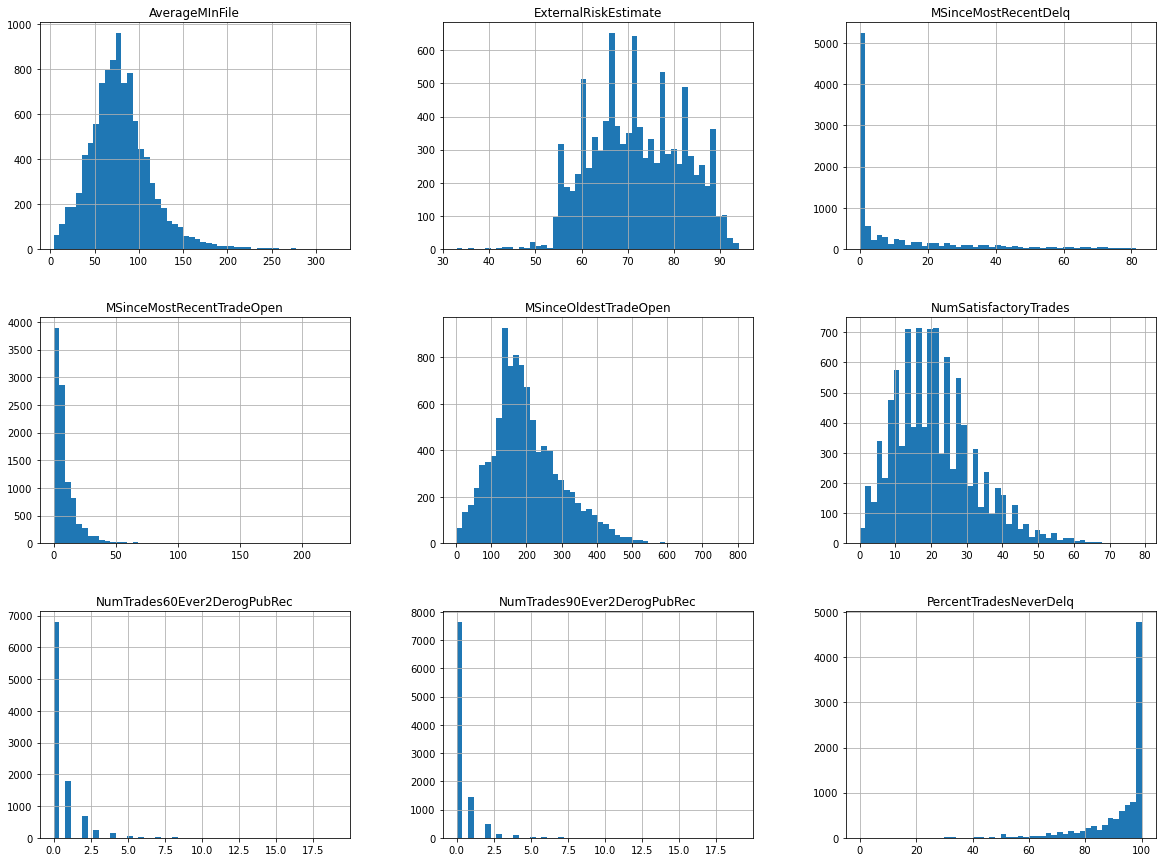

In [12]:
heloc.iloc[:,1:10].hist(bins=50, figsize=(20,15))

From the charts above, we could see measurement unit of each feature of the system are different.Thus,we need to standardize features using standard scaler for some machine learning models that are sensitive to the scale of the number.

### Building and Tuning Model

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree  
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [14]:
X = heloc.drop(["RiskPerformance"], axis=1)
y = heloc["RiskPerformance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [76]:
model_names = ['LR','LDA','SVM','KNN','DT','RF','GB','LGB']


param_grid_lr = [{'C':[0.01,0.1,1],'random_state':[1]}]
param_grid_dt =[{ 'max_features':range(1,20),'max_depth':range(1,50),'random_state':[1]}]
param_grid_rf = [{ 'n_estimators':[50, 100,150,200],'max_features':[0.2, 0.3, 0.5, 0.8], 'bootstrap':[True],'random_state':[1]}]
param_grid_gb= [{ 'n_estimators': [25, 50, 80, 100, 200],
                 'learning_rate': [.05, .1, .2,.5,1], 
                 'max_depth': [1,3,5],
                 'random_state':[1]}]
param_grid_lda = [{}]
param_grid_knn =[{},{'n_neighbors':[1,2,3,4,5]}]  
param_grid_lgb=[{'learning_rate': [0.001,0.003,0.01,0.05,0.051, 0.052, 0.055],'objective':['binary'],'metric':['binary_logloss'],'boosting_type':['goss'],'max_depth':[5],'num_leaves':[10]}]
param_grid_svm=[{'kernel':['linear', 'rbf'],'C': [0.1,0.5,1]}]

classifiers= [(LogisticRegression(), model_names[0], param_grid_lr),
              (LinearDiscriminantAnalysis(), model_names[1], param_grid_lda),
              (SVC(gamma='auto',probability=True),model_names[2],param_grid_svm),
            (neighbors.KNeighborsClassifier(), model_names[3], param_grid_knn),
            (tree.DecisionTreeClassifier(), model_names[4], param_grid_dt),
            (RandomForestClassifier(), model_names[5], param_grid_rf),
            (GradientBoostingClassifier(), model_names[6], param_grid_gb),
             (LGBMClassifier(),model_names[7],param_grid_lgb)]



def evaluate_model(X_train,X_test,y_train, y_test, model, model_name, params):   
    grid_search = GridSearchCV(model, params, cv=5,n_jobs=-1,scoring='roc_auc') 
    grid_search.fit(X_train,y_train)
       
    model_selection = grid_search.best_estimator_ 
    #predictions = model_selection.predict(X_test)
    prob = model_selection.predict_proba(X_test)
    pred = prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, pred)
    AUC = auc(fpr, tpr)
    # accuracy = (y_test==predictions).mean() 
    model_dic = {} 
    model_dic['Classifier'] = model_name 
    model_dic['Best Parameter'] = grid_search.best_estimator_.get_params()
    model_dic['CV AUC'] = grid_search.best_score_ 
    model_dic['Overall AUC'] = AUC
    return model_dic
  


In [ ]:
'n_estimators':[200],
                 'num_leaves' :[5],
                 'min_data_in_leaf':[4],
                 'max_depth':[5],
                 'max_bin':[55],
                 'bagging_fraction':[0.5],
                 'bagging_freq':[5],
                 'feature_fraction':[0.24],
                 'feature_fraction_seed':[9],
                 'bagging_seed':[9],
                 'min_sum_hessian_in_leaf':[11]}

In [77]:
res_list = []
for i in range(len(classifiers)):
    if i<4:
        #scale data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test= scaler.transform(X_test)
        res_list.append(evaluate_model(X_train,X_test,y_train, y_test, classifiers[i][0], classifiers[i][1], classifiers[i][2]))
    else:
        res_list.append(evaluate_model(X_train,X_test,y_train, y_test, classifiers[i][0], classifiers[i][1], classifiers[i][2]))
    
result_table = pd.DataFrame(res_list).sort_values(by=['Classifier']).reset_index(drop=True)
    
    
result_table

,Classifier,Best Parameter,CV AUC,Overall AUC
0,DT,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.775609,0.758635
1,GB,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.805304,0.790623
2,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.741789,0.729655
3,LDA,"{'n_components': None, 'priors': None, 'shrink...",0.803859,0.788343
4,LGB,"{'boosting_type': 'goss', 'class_weight': None...",0.803449,0.791268
5,LR,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.803562,0.788169
6,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.798032,0.783450
7,SVM,"{'C': 1, 'break_ties': False, 'cache_size': 20...",0.803184,0.787669


In [32]:
result_table.iloc[5,1]

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 5,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'boosting': 'goss',
 'metric': 'binary_logloss'}

In [41]:
def plot(model, plotROC=False):
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)
    pred = prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    # Find optimal threshold
    rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
    rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
    optimalthreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]
    
    # Get accuracy over the test set
    y_pred = np.where(pred >= optimalthreshold, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    if plotROC:
        plt.title('AUC_ROC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

AUC: 0.7913
Accuracy: 72.93%


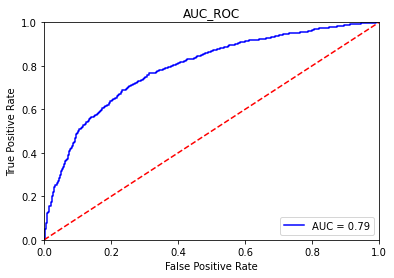

In [57]:
lgb_model = LGBMClassifier(learning_rate=0.051, objective='binary',metric='binary_logloss',
                       boosting_type='goss', max_depth=5, num_leaves=10)
plot(lgb_model,plotROC=True)

In [59]:
imp=pd.DataFrame()
imp['imp'] = lgb_model.feature_importances_
imp['name'] = lgb_model.feature_name_ 
imp=imp.sort_values(by=['imp'],ascending=False)


,imp,name
0,101,Column_0
15,88,Column_15
3,88,Column_3
4,76,Column_4
12,71,Column_12
11,70,Column_11
1,64,Column_1
7,52,Column_7
20,40,Column_20
16,38,Column_16


In [72]:
for i in X.columns[[0,15,3,4,12]]:
    print(i)

ExternalRiskEstimate
NetFractionRevolvingBurden
AverageMInFile
NumSatisfactoryTrades
MSinceMostRecentInqexcl7days


### Interface Preparation

In [90]:
import pickle
from sklearn.pipeline import Pipeline

In [91]:
X1 = heloc.drop(["RiskPerformance"], axis=1)
y1 = heloc["RiskPerformance"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1)

In [92]:
data = pd.read_csv('heloc_dataset_v1.csv')

In [93]:
X = data.drop(["RiskPerformance"], axis=1)
y = data["RiskPerformance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [94]:
X1_train.shape[1]

37

In [95]:
pipe_rf = Pipeline([('Random Forest',RandomForestClassifier(bootstrap = True,
                                                             class_weight = None,
                                                             criterion = 'gini',
                                                             max_depth = None,
                                                             max_features = 0.2,
                                                             max_leaf_nodes = None,
                                                             min_impurity_decrease = 0.0,
                                                             min_impurity_split = None,
                                                             min_samples_leaf = 1,
                                                             min_samples_split = 2,
                                                             min_weight_fraction_leaf = 0.0,
                                                             n_estimators = 200,
                                                             n_jobs = None,
                                                             oob_score = False,
                                                             random_state = 1,
                                                             verbose = 0,
                                                             warm_start = False))])
pipe_rf.fit(X1_train,y1_train)


Pipeline(steps=[('Random Forest',
                 RandomForestClassifier(max_features=0.2, n_estimators=200,
                                        random_state=1))])

In [96]:
pickle.dump(X_train, open("X_train.sav", "wb"))
pickle.dump(X_test, open("X_test.sav", "wb"))
pickle.dump(y_test, open("y_test.sav", "wb"))
pickle.dump(pipe_rf, open("pipe_rf.sav", "wb"))